<div style="color:red;background-color:black">
Diamond Light Source

<h1 style="color:red;background-color:antiquewhite"> Python Fundamentals: Curve Fitting</h1>  

©2000-20 Chris Seddon 
</div>

Execute the following cell to activate styling for this tutorial

In [1]:
from IPython.display import HTML
HTML(f"<style>{open('my.css').read()}</style>")

## 1
At Diamond we oftn need to fit experimental data.  Python offers support with several libraries:
* numpy
* scipy
* matplotlib
* hdf5
In particular we often need to analyse Nexus files and a number of samples are used in this tutorial.  The Nexus files are stored in the nexus sub-directory:

In [2]:
%%bash
ls nexus

MoKedge_1_15.nxs
i22-4996.nxs


## 2
Before we start analysing these files, we need to see how to use SciPy to perform curve fitting.  If we generate some sample data and add some noise we can try out fitting a simple polynominal.

Suppose we wish to fit the polynomial:
$$y = ax^2 + bx + c$$
where a, b and c are unknown constants.  
We can create some test data and plot it with the following code:

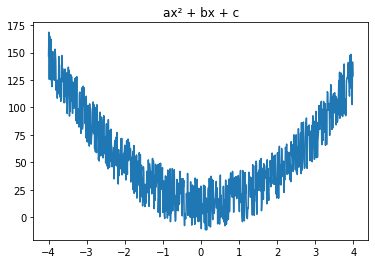

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


ax = plt.gca()
ax.set_title("ax" + chr(0x00B2) + " + bx + c")

x = np.arange(-4, 4, 0.01)
noise = np.random.rand((len(x)))-0.5 # between -0.5 and 0.5
y = 7.8*x**2 - 2.3*x + 13.4 + 50 * noise
plt.plot(x, y)
print()

## 3 
Now we define the function to fit.  The function must have the input variable "x" as the first parameter, followed by all the unknown constants (a, b and c in our case).  The function must return "y".  SciPy will use the experimental data to estimate value for the unknown constants.  

SciPy curve fitting is designed for one dimensional fits.  It is possible to adapt the algorithm to multiple dimensions, but it is not straightford to do so.

Here is our fitting function:

In [21]:
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

## 4
We can perform the fit using SciPy's "curve_fit" method.  The method takes a pointer to our fit function, followed by the "x" and "y" experimental data.  The last parameter is a list of initial guesses for the 3 unknown constants.  If the initial guess is too far off, the fitting will fail.  Usually it's fairly easy to come up with some reasonable estimates.

In [26]:
import scipy.optimize

def initialGuess():    
    a = 5
    b = 0
    c = 8
    return [a, b, c]

fit, estimated_covariance = scipy.optimize.curve_fit(quadratic, x, y, p0=initialGuess())
print(f"estimates of [a, b, c] are {fit}")

estimates of [a, b, c] are [ 7.70191817 -2.08454025 14.44490146]


## 5
The curve fit returns estimates of the unknown constants and the estimated covariance.  The covariance information is discussed in SciPy documentation:
* <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit">scipy.optimize.curve_fit</a>

All that remains it to plot the fit against the experimental data:

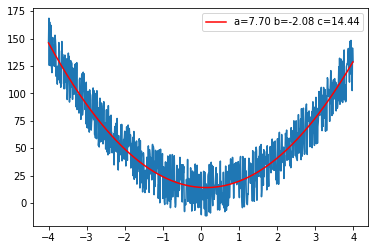

In [27]:
plt.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.plot(x, quadratic(x, *fit), 'r-',
         label=f'a={fit[0]:.2f} b={fit[1]:.2f} c={fit[2]:.2f}')
plt.legend()
plt.show()

## 6
The three constants are reasonably accurate, especially in view of the large noise component.  Reduce the noise and we'd be even more accurate:

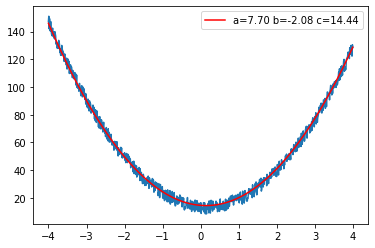

In [29]:
y = 7.8*x**2 - 2.3*x + 13.4 + 10 * noise
plt.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.plot(x, quadratic(x, *fit), 'r-',
         label=f'a={fit[0]:.2f} b={fit[1]:.2f} c={fit[2]:.2f}')
plt.legend()
plt.show()